In [1]:
#%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util
import plot as sds_plt

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pyshtools
import pickle

import datetime as dt
from viresclient import SwarmRequest

comment = "Showcase SDSSIM on the VRE"
nb_name = "nb_seqsim_core_swarm_dqw"

shn = 20
C_e_const = 3.0

# Swarm obs VRE

In [2]:
request = SwarmRequest()

request.set_collection("SW_OPER_MAGA_LR_1B")

#request.set_products(measurements=["F","B_NEC"],
#                     models=["MCO_SHA_2C", "MMA_SHA_2C-Primary", "MMA_SHA_2C-Secondary"],
#                     auxiliaries=["QDLat", "QDLon", "MLT", "OrbitNumber", "SunZenithAngle"],
#                     residuals=False,
#                     sampling_step="PT10S")

request.set_products(measurements=["B_NEC"],
                     models = ["CHAOS-MMA-Primary", "LCS-1"],
                     auxiliaries=["SunZenithAngle", "Kp"],
                     residuals=False,
                     sampling_step="PT120S")

request.set_range_filter(parameter="Latitude", minimum= -90, maximum=90)

request.set_range_filter("Longitude", -180, 180)

data = request.get_between(start_time=dt.datetime(2016,1,1),
                           end_time=dt.datetime(2016,1,5))

[1/1] Processing:  100%|██████████|  [ Elapsed: 00:03, Remaining: 00:00 ]
      Downloading: 100%|██████████|  [ Elapsed: 00:00, Remaining: 00:00 ] (0.37MB)


In [3]:
ds = data.as_xarray()
print(ds)

<xarray.Dataset>
Dimensions:                  (NEC: 3, Timestamp: 2880)
Coordinates:
  * Timestamp                (Timestamp) datetime64[ns] 2016-01-01 ... 2016-01-04T23:58:00
  * NEC                      (NEC) <U1 'N' 'E' 'C'
Data variables:
    Spacecraft               (Timestamp) object 'A' 'A' 'A' 'A' ... 'A' 'A' 'A'
    Kp                       (Timestamp) float64 5.7 6.0 6.0 6.0 ... 0.7 0.7 0.7
    Longitude                (Timestamp) float64 92.79 99.1 ... -90.64 -82.1
    B_NEC_CHAOS-MMA-Primary  (Timestamp, NEC) float64 -18.15 -1.797 ... 22.24
    B_NEC_LCS-1              (Timestamp, NEC) float64 -0.2608 2.703 ... -7.421
    Radius                   (Timestamp) float64 6.834e+06 ... 6.816e+06
    Latitude                 (Timestamp) float64 -72.5 -80.01 ... 74.16 81.66
    SunZenithAngle           (Timestamp) float64 67.46 65.78 ... 111.0 113.3
    B_NEC                    (Timestamp, NEC) float64 -1.581e+03 ... 4.672e+04
Attributes:
    Sources:         ['LCS-1.shc', 'SW_OPER

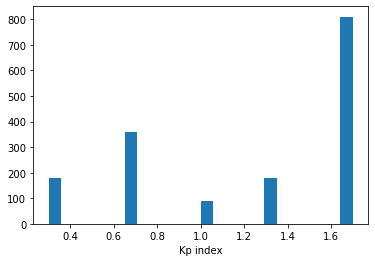

In [4]:
SZA_angle = 60
Kp_max = 2
idx_sort= np.logical_and(np.abs(ds.SunZenithAngle)>SZA_angle,ds.Kp<Kp_max)

plt.figure()
plt.hist(ds.Kp[idx_sort],bins=24)
plt.xlabel("Kp index")
plt.show()

In [5]:
obs_sat = SDSS(comment, N_SH = shn, sim_type = "core", sat_height = 350, N_SH_secondary = None)

obs_sat.data = np.array(-ds.B_NEC[:,2][idx_sort] + ds["B_NEC_CHAOS-MMA-Primary"][:,2][idx_sort] + ds["B_NEC_LCS-1"][:,2][idx_sort])
#obs_sat.data = np.array(ds["B_NEC_CHAOS-MMA-Primary"][:,2][idx_sort])
#obs_sat.data = np.array(ds["B_NEC_LCS-1"][:,2][idx_sort])

obs_sat.r_grid = np.array(ds.Radius[idx_sort])/10**3
obs_sat.lon = np.array(ds.Longitude[idx_sort]) + 180
obs_sat.lat = np.array(ds.Latitude[idx_sort])
obs_sat.swarm_N = len(obs_sat.data)



#B_s_t = -ds.B_NEC[:,0][idx_sort] + ds["B_NEC_CHAOS-MMA-Primary"][:,0][idx_sort]
#B_s_p = ds.B_NEC[:,1][idx_sort] - ds["B_NEC_CHAOS-MMA-Primary"][:,1][idx_sort]

In [6]:
print(obs_sat)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          Showcase SDSSIM on the VRE
class_abs_path:   /home/jovyan/spherical_direct_sequential_simulation
N_SH:             20
N_SH_secondary:   None
sim_type:         core
data:             (1619,), Max/Min: 52843.40 / -48650.78
r_grid:           (1619,), Max/Min: 6834.05 / 6815.79
lon:              (1619,), Max/Min: 359.80 / 0.49
lat:              (1619,), Max/Min: 87.35 / -87.35
swarm_N:          1619



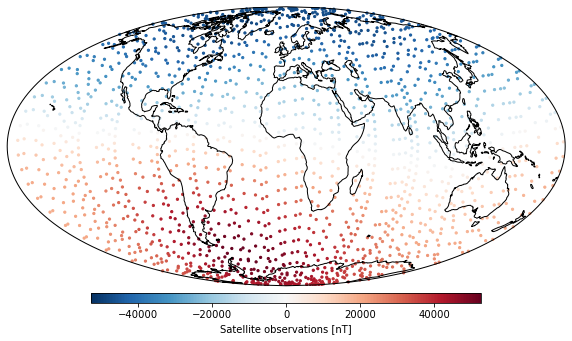

In [7]:
mt_util.plot_cartopy_global(lat = obs_sat.lat, lon = obs_sat.lon, plot_quality = "high", point_size=5, 
                            data=obs_sat.data, title="Satellite observations")

# Core

In [8]:
core = SDSS(comment, N_SH = shn, sim_type = "core", sat_height = 350)

core.grid_glq(nmax = shn, r_at = core.r_cmb)

grid_in = np.array([core.grid_glq_phi, 90-core.grid_glq_theta]).T
core.make_grid(core.r_cmb, grid_in, calc_sph_d = True)


In [9]:
core.generate_map(target_var_factor = 1)

In [10]:
#core.data = core.data - np.mean(core.data)

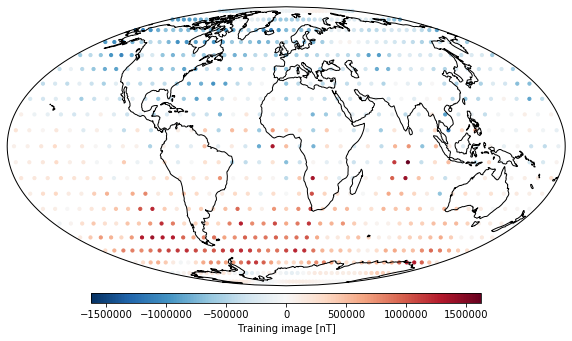

In [11]:
mt_util.plot_cartopy_global(lat = core.lat, lon = core.lon, plot_quality = "high", 
                            data=core.data, point_size=10, shape = (121,61), 
                            title="Training image")

In [12]:
core.condtab(normsize=1000, quantiles = 100, 
             rangn_lim = 3.5, rangn_N = 101, rangv_lim = 2.0, rangv_N = 101)

____semi-variogram setup___

Number of data used: 741321
Max data distance: 10902.989 km
Lag length chosen: 200.0 km
Number of lags: 54
Number of modelling lags: all

Semi-variogram model determined, starting LUT computation

____semi-variogram setup___

Number of data used: 741321
Max data distance: 10902.989 km
Lag length chosen: 200.0 km
Number of lags: 54
Number of modelling lags: 20

Semi-variogram model determined, starting LUT computation



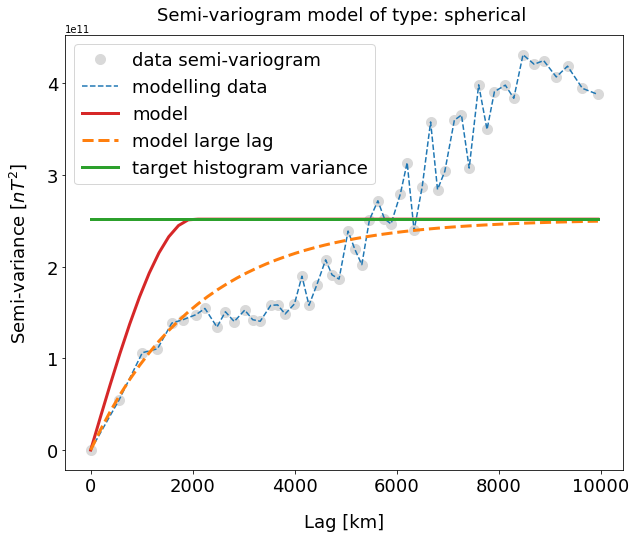

In [13]:
core.semivar(model_lags = "all", model = "exponential", max_dist = 20000, lag_length = 200,
             zero_nugget = True, hit_target_var = True)

keep_sv_curve = core.sv_curve.copy()
keep_lags_sv_curve = core.lags_sv_curve.copy()

nugget = C_e_const**2
nugget_p = 0.01
var_fac = 1.0

#set_model = {"a": 2000, "C0": var_fac*core.target_var*nugget_p, "C1": var_fac*core.target_var*(1-nugget_p), "C2": None, "C3": None}
set_model = {"a": 2000, "C0": nugget, "C1": var_fac*core.target_var-nugget, "C2": None, "C3": None}


core.semivar(model_lags = 20, model = "spherical", max_dist = 20000, lag_length = 200,
             zero_nugget = True, hit_target_var = True, set_model = set_model)

#core.semivar(model_lags = 3, model = "exponential", max_dist = 20000, lag_length = 200,
#             zero_nugget = True, hit_target_var = True)


#%% PLOT SEMI-VARIOGRAM
plt.figure(figsize=(10,8)) 
plt.plot(core.lags,core.pics,'o', markersize=10,color = '0.85',label='data semi-variogram')
plt.plot(core.lags_model,core.pics_model,'--',markersize=10,label='modelling data')
plt.plot(core.lags_sv_curve,core.sv_curve,color='C3', linewidth = 3,label='model')
plt.plot(keep_lags_sv_curve,keep_sv_curve,"--",color='C1',linewidth = 3,label='model large lag')

plt.plot(core.lags_sv_curve,np.ones(core.lags_sv_curve.shape)*core.target_var,linewidth = 3, color="C2", label="target histogram variance")
plt.ylabel('Semi-variance $[%s^2]$' % "nT",fontsize=18,labelpad=18)
plt.xlabel('Lag [km]',fontsize=18,labelpad=18)
plt.title("Semi-variogram model of type: %s " % core.model_names[core.model],fontsize=18,y=1.02)
plt.legend(loc='best',fontsize=18)
ax = plt.gca()
ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
plt.show()

In [14]:
print(core)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               Showcase SDSSIM on the VRE
class_abs_path:        /home/jovyan/spherical_direct_sequential_simulation
N_SH:                  20
N_SH_secondary:        None
sim_type:              core
grid_glq_zero:         (21,), Max/Min: 0.99 / -0.99
grid_glq_w_shtools:    (21,), Max/Min: 0.15 / 0.02
grid_glq_shape:        (2,), Max/Min: 41.00 / 21.00
grid_glq_w:            (861,), Max/Min: 0.15 / 0.02
grid_glq_radial:       (861,), Max/Min: 3480.00 / 3480.00
grid_glq_theta:        (861,), Max/Min: 173.59 / 6.41
grid_glq_phi:          (861,), Max/Min: 351.22 / 0.00
grid_glq_N:            861
grid_glq_nmax:         20
r_grid:                3480.0
grid:                  (861, 2)
sph_d:                 (861, 861)
lon:                   (861,), Max/Min: 351.22 / 0.00
lat:

# Synthetic sat

In [15]:
s_sat = SDSS(comment, N_SH = shn, sim_type = "core", sat_height = 350, N_SH_secondary = None)

s_sat.load_swarm("A")

grid_in = np.array([s_sat.swarm_phi, 90-s_sat.swarm_theta]).T
s_sat.make_grid(s_sat.swarm_radius, grid_in, calc_sph_d = False)

#s_sat.grid_equal_area(N_grid= 500, r_at = s_sat.r_sat, poles_remove = True)
#grid_in = np.array([s_sat.grid_eqa_phi, 90-s_sat.grid_eqa_theta]).T
#s_sat.grid(s_sat.r_sat, grid_in, calc_sph_d = False)

In [16]:
s_sat.generate_map(grid_type = "swarm")

In [17]:
s_sat.data += np.random.normal(scale = C_e_const, size = s_sat.data.shape)

In [10]:
#mt_util.plot_cartopy_global(lat = s_sat.lat, lon = s_sat.lon, plot_quality = "high", point_size=5, 
#                            data=s_sat.data, cmap = 'PuOr_r', title="Synthetic satellite data")

In [18]:
print(s_sat)


______current attributes______

a:                6371.2
r_sat:            6721.2
r_cmb:            3480.0
rad:              0.017453292519943295
mu0:              1.2566370614359173e-06
comment:          Showcase SDSSIM on the VRE
class_abs_path:   /home/jovyan/spherical_direct_sequential_simulation
N_SH:             30
N_SH_secondary:   None
sim_type:         core
swarm_theta:      (2773,), Max/Min: 177.35 / 22.39
swarm_phi:        (2773,), Max/Min: 179.68 / -179.59
swarm_radius:     (2773,), Max/Min: 6825.19 / 6806.85
swarm_obs:        (2773,), Max/Min: 53117.43 / -48881.72
swarm_N:          2773
r_grid:           (2773,), Max/Min: 6825.19 / 6806.85
grid:             (2773, 2)
sph_d:            None
lon:              (2773,), Max/Min: 179.68 / -179.59
lat:              (2773,), Max/Min: 67.61 / -87.35
N_grid:           2773
B_ensemble_swarm: (2773, 3)
data:             (2773,), Max/Min: 85929.69 / -84417.05
target_var:       2650032519.9717584
target_mean_true: 18356.49194207425
ta

# SDSSIM


Gauss-Legendre RMSE:	 25934.593806215587


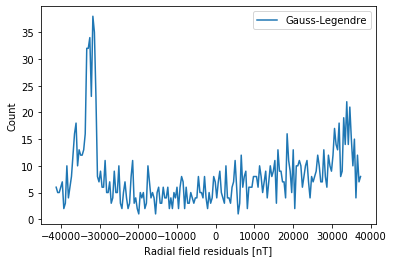

In [15]:
core.integrating_kernel(obs_sat, C_e_const = C_e_const)

In [16]:
core.covmod_lsq_equiv(obs_sat.data, core.C_mm_all, core.G, core.r_cmb)

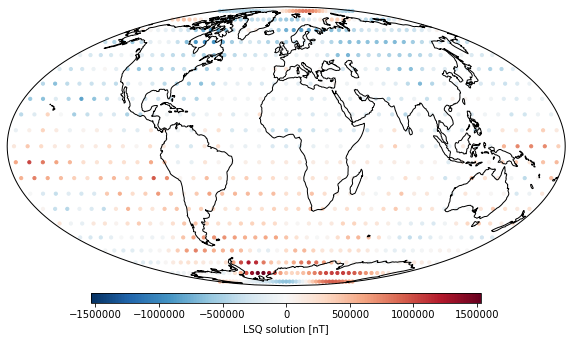

In [17]:
mt_util.plot_cartopy_global(lat = core.lat, lon = core.lon, plot_quality = "high", 
                            data=np.ravel(core.m_equiv_lsq), point_size=10, 
                            title="LSQ solution")

 |OOOOOOOOOO| 100.0%   realization nr. 0. Counter: 861/861, Running error magnitude: 5.4
Run time: 14.682 minutes 
Total elapsed time: 14.682 minutes 
Variance: 196540396347.625
Mean: 4077.236
Max: 1649221.205
Min: -1187120.493
Run nr.: 1

 |OOOOOOOOOO| 100.0%   realization nr. 1. Counter: 861/861, Running error magnitude: 5.4
Run time: 14.445 minutes 
Total elapsed time: 29.126 minutes 
Variance: 200847116468.621
Mean: 4296.574
Max: 1713239.759
Min: -982148.180
Run nr.: 2

 |OOOOOOOOOO| 100.0%   realization nr. 2. Counter: 861/861, Running error magnitude: 5.4
Run time: 14.430 minutes 
Total elapsed time: 43.556 minutes 
Variance: 186142533651.878
Mean: 3201.389
Max: 1700052.617
Min: -1134615.881
Run nr.: 3

 |OOOOOOOOOO| 100.0%   realization nr. 3. Counter: 861/861, Running error magnitude: 5.4
Run time: 14.398 minutes 
Total elapsed time: 57.954 minutes 
Variance: 189727552027.777
Mean: 4636.872
Max: 1728870.019
Min: -1193688.609
Run nr.: 4


Seqsim RMSE:	 [[9.7862374  9.78962697 9.

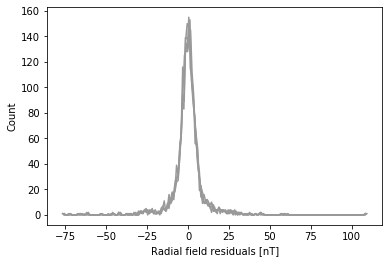

In [19]:
N_sim = 4

core.run_sim(N_sim, core.grid_glq_N, core.C_mm_all, core.C_dd, core.C_dm_all, core.G,
        obs_sat.data, core.data, scale_m_i = True, unit_d = False, collect_all = False,
        sense_running_error = True, save_string = nb_name, sim_stochastic = False)

In [20]:
core.realization_to_sh_coeff(core.r_cmb, set_nmax = shn)

# Evaluation

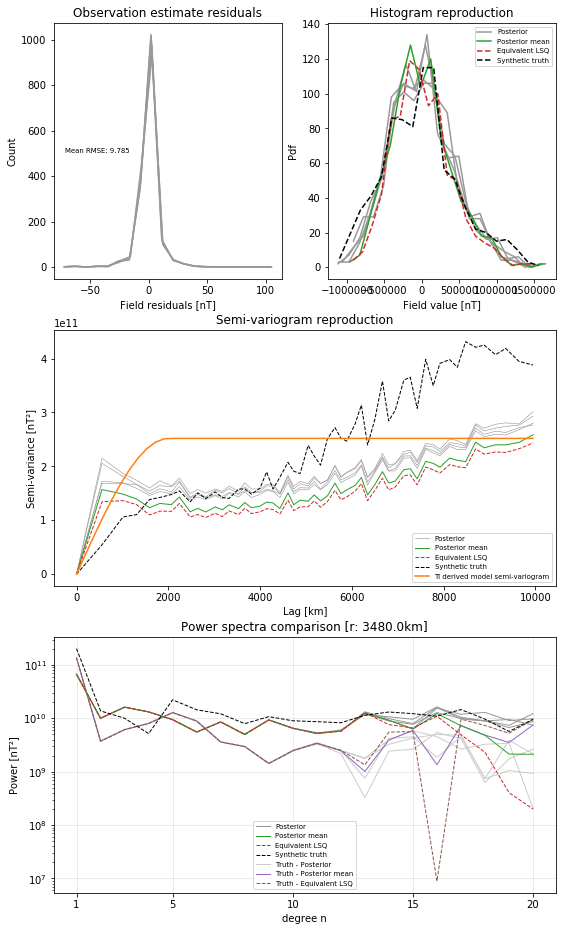

In [21]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

core.grid_glq(nmax = shn, r_at = core.r_cmb)
mt_util.plot_sdssim_reproduce(core, core.m_DSS_res, m_equiv_lsq = core.m_equiv_lsq,
                              lags_use = 1000, spec_r_at = core.r_cmb,
                              model_dict = None, figsize=(9,16),
                              hist_bins = 20, res_bins = 20,
                              savefig = False, save_string = "core_sh30_unconditional_compare", save_dpi = 300)

In [22]:
core.grid_glq(nmax = 256, r_at = core.r_cmb)
#core.grid_glq(nmax = 120, r_at = core.r_cmb)

set_nmax = shn

core.ensemble_B(core.g_spec, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_eqa = core.B_ensemble_glq[:,0,:].copy()

#core.g_spec_mean = np.mean(core.g_spec,axis=1)
core.ensemble_B(core.g_spec_mean, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
zs_mean_eqa = core.B_ensemble_glq[:,0].copy()

core.ensemble_B(core.g_prior[:mt_util.shc_vec_len(set_nmax)], nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
prior_eqa = core.B_ensemble_glq[:,0].copy()

core.ensemble_B(core.g_lsq_equiv, nmax = set_nmax, r_at = core.r_cmb, grid_type = "glq")
lsq_eqa = core.B_ensemble_glq[:,0].copy()

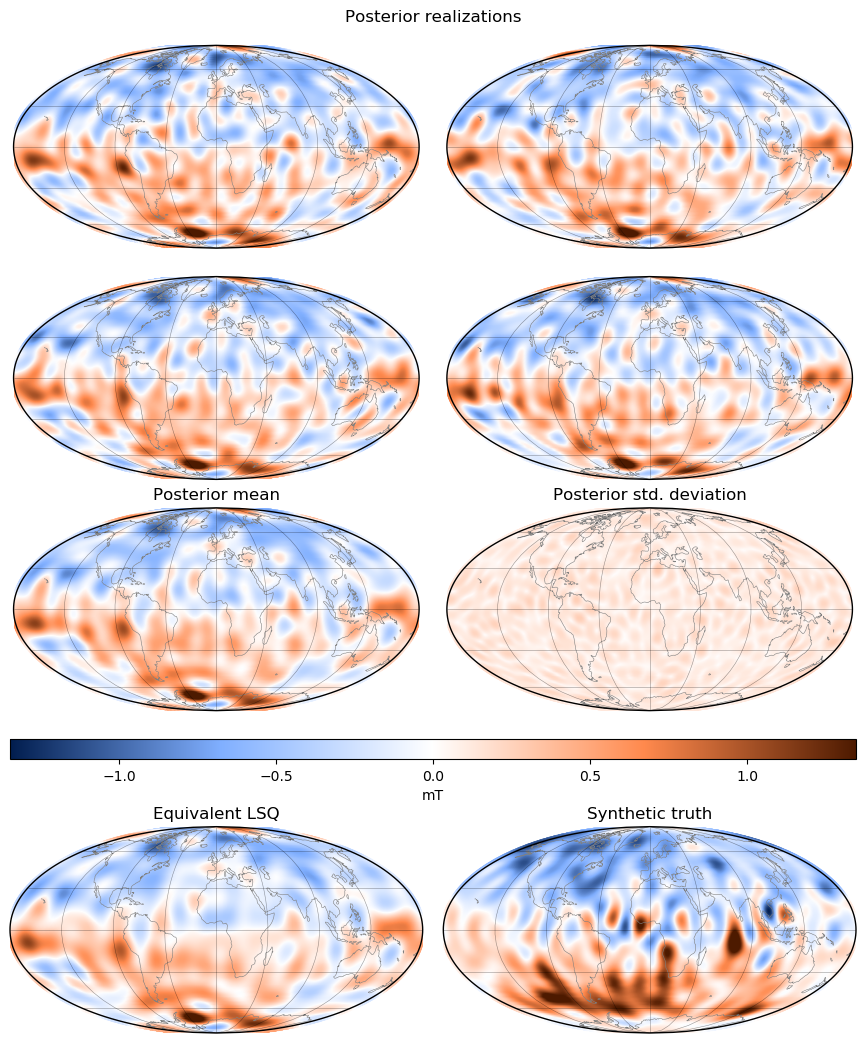

In [23]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(core.grid_glq_phi, 90-core.grid_glq_theta, zs_eqa, 
                        field_compare = prior_eqa, field_lsq = lsq_eqa, field_mean = zs_mean_eqa,
                        tile_size_row = 3, tile_size_column = 2, 
                        figsize=(9,12), limit_for_SF = 10**6, point_size = 10, cbar_mm_factor = 2/3,
                        coast_width = 0.4, coast_color = "grey", unit_transform_n_to_m = True,
                        cbar_h = 0.1, cbar_text = "mT", cbar_text_color = "black",
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.2, 
                        savefig = False, save_string = "core_sh30_unconditional_compare", 
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


In [23]:
# SAVE RESULT
#print("\nSaving job")
#file_clip = open("core_{}.obj".format(nb_name), "wb")
#pickle.dump(core, file_clip, protocol=4)
#file_clip.close()

#file_clip = open("sat_{}.obj".format(nb_name), "wb")
#pickle.dump(s_sat, file_clip, protocol=4)
#file_clip.close()
#print("\nJob saved and finished")